In [1]:
import pandas as pd
import numpy as np
import nltk; nltk.download('punkt')
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
df = pd.read_csv('/content/questions.csv')
questions = df['Main Question'].tolist()

In [3]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()


In [4]:
processed_questions = [preprocess(q) for q in questions]

In [5]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(processed_questions)
terms = tfidf.get_feature_names_out()

In [6]:
def search_similarity(query, questions, vectorizer, tfidf_matrix, top_n=5):
    query_vec = vectorizer.transform([query])
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    indices = np.argsort(similarities)[::-1][:top_n]
    return [(questions[i], similarities[i]) for i in indices]

In [7]:
query = "Does the company have membership in any organizations promoting supplier diversity?"
similar = search_similarity(query, questions, tfidf, tfidf_matrix)
print("\nSimilar Questions:")
for q, score in similar:
    print(f"- {q} (Score: {score:.2f})")


Similar Questions:
- Does the company have membership in any organizations promoting supplier diversity (e.g., The National Minority Supplier Diversity Council (NMSDC), Women Business Enterprise National Council (WBENC), etc)? (Score: 0.60)
- Does the company have any employees or resources located outside the U.S.? (Score: 0.18)
- Does the supplier notify the entity of any vulnerabilities in its products or services promptly, ensuring it does not increase threat vectors? (Score: 0.18)
- Does the supplier have a product change notification (PCN) process that is compliant with a recognized industry standard? (Score: 0.17)
- For which of these does your company establish and maintain baseline configurations and inventories? (Score: 0.16)


In [8]:
kmeans = KMeans(n_clusters=9, random_state=42)
df['Cluster'] = kmeans.fit_predict(tfidf_matrix)

In [9]:
def get_cluster_terms(vectorizer, kmeans, n_terms=5):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    cluster_terms = {}
    for i in range(kmeans.n_clusters):
        cluster_terms[i] = [terms[idx] for idx in order_centroids[i, :n_terms]]
    return cluster_terms

cluster_terms = get_cluster_terms(tfidf, kmeans)

In [10]:
cluster_names = {
    0: 'Data Protection & Compliance',
    1: 'Access Management & Authentication',
    2: 'AI & Advanced Technologies',
    3: 'Vendor Management & Contracts',
    4: 'Incident Response',
    5: 'Backup & Recovery',
    6: 'Network Security',
    7: 'GDPR & PII Handling',
    8: 'Development Practices'
}

In [11]:
df['Cluster Name'] = df['Cluster'].map(cluster_names)

In [12]:
print("\nSample Questions by Cluster:")
for cluster_id, name in cluster_names.items():
    sample_questions = df[df['Cluster'] == cluster_id]['Main Question'].sample(2).tolist()
    print(f"\nCluster {name}:")
    for q in sample_questions:
        print(f"- {q}")


Sample Questions by Cluster:

Cluster Data Protection & Compliance:
- Does the service provider ensure that its processes and policies are compliant with relevant country data protection laws of the client's operating countries?
- Do you have an anti-virus & anti-malware solution deployed covering every endpoint in your infrastructure? If yes, please provide details.

Cluster Access Management & Authentication:
- Do you have a person in charge of the handling of Personal Information, etc.?
- Can we agree on provisions in the contract for investigation? (What would we have access to and how? documentation for auditors?)

Cluster AI & Advanced Technologies:
- Could you provide a network and data flow diagram showing wireless connectivity? Additionally, can you share evidence confirming the correct configuration of all wireless access points used? Furthermore, do you have evidence of regular vulnerability scans for unauthorized wireless access points? Also, what measures are in place to 

In [13]:
df[['Main Question', 'Cluster Name']].to_csv('clustered_questions.csv', index=False)

In [14]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

In [15]:
print("\nCluster Topics:")
for i in range(9):
    cluster_labels = [terms[ind] for ind in order_centroids[i, :5]]
    print(f"Cluster {i+1}: {', '.join(cluster_labels)}")


Cluster Topics:
Cluster 1: details, country, provide, data, datacenter
Cluster 2: information, personal, contract, sensitive, social
Cluster 3: password, authentication, logs, application, security
Cluster 4: use, clients, vendor, data, ensure
Cluster 5: data, provide, require, service, privacy
Cluster 6: does, company, management, organization, identify
Cluster 7: access, client, data, business, users
Cluster 8: process, changes, automated, unique, identities
Cluster 9: services, health, provider, benefit, years


In [16]:
df_clusters = pd.read_csv('/content/clustered_questions.csv')

In [17]:
df_clusters.head()

,Main Question,Cluster Name
0,Are there information security requirements fo...,Development Practices
1,What is the password history before reuse?,AI & Advanced Technologies
2,What controls are in place for accessing produ...,Vendor Management & Contracts
3,Is this system developed and tested using secu...,AI & Advanced Technologies
4,What kind of AI is in use?\n- Deep Learning\n-...,Vendor Management & Contracts


In [18]:
keywords = ["how", "what", "which", "do", "does", "is"]
counts = {kw: sum(q.startswith(kw) for q in processed_questions) for kw in keywords}

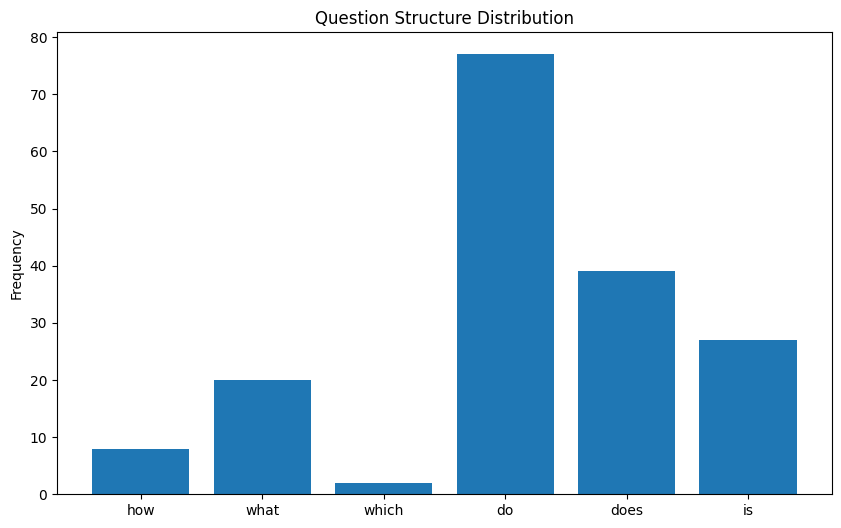

In [19]:
plt.figure(figsize=(10,6))
plt.bar(keywords, counts.values())
plt.title("Question Structure Distribution")
plt.ylabel("Frequency")
plt.show()


In [20]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=20)
cnt_matrix = count_vectorizer.fit_transform(processed_questions)
word_freq = sorted(zip(count_vectorizer.get_feature_names_out(), np.asarray(cnt_matrix.sum(axis=0)).ravel()),
                  key=lambda x: x[1], reverse=True)

In [21]:
print("\nTop Keywords:")
for word, freq in word_freq[:20]:
    print(f"{word}: {freq}")



Top Keywords:
data: 49
does: 48
security: 27
provide: 26
client: 24
information: 24
access: 23
organization: 19
application: 15
process: 15
systems: 14
service: 13
company: 12
personal: 12
use: 12
clients: 11
password: 11
place: 11
services: 11
solution: 11


In [22]:
def security_search(query, top_n=5):
    results = search_similarity(query, questions, tfidf, tfidf_matrix, top_n)
    return [item[0] for item in results]

In [23]:
user_query = "How does your organization handle data breaches?"
print("\nSearch Results for:", user_query)
print(security_search(user_query))


Search Results for: How does your organization handle data breaches?
['Does your organization ensure that no live data, especially personal data, is used in test/development environments?', "Does the organization directly or jointly collect personal data from the individuals (client's employees, prospects, customers etc.) as a part of services provided to the client? If yes, does the organization provide a privacy notice to the individuals before collecting the information?", 'Has the organization been subject to any enforcement actions by regulators for breaches of relevant Occupational Health and Safety (OHS) legislation or an EU directive in the last three years?', 'Does your organization have a patch management process for minor and major products?', 'Does your organization require workforce members to take phishing training annually?']
